# Position Predictor (In Progress)

`Given the position of 1,3,5 players + ball have the model try and predict the position of the other player.`

The intent of this notebook is to document model selection for this position prediction task.

In [68]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import itertools
import random
import xgboost as xgb
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.multioutput import MultiOutputRegressor

In [2]:
# CONFIGS
POSITION_COLUMNS = ['pos_x', 'pos_y', 'pos_z']
NCOLS = len(POSITION_COLUMNS)
RANDOM_SEED = 42
TEST_RATIO = 0.2
VALIDATE_RATIO = 0.2
PARTITION_RANGE = 1000
CACHE_PATH = "./.replay_cache"

In [3]:
random.seed(RANDOM_SEED)

## Data Exploration

Before doing anything, I need to just get a grip on what the data is and what can be done with it.

In [4]:
import data
importlib.reload(data)
data_manager = data.FileCachedCalculated()

Caching replays at: /home/axelmagn/.replays_cache


In [5]:
replays = data_manager.get_replay_list(num=10)

In [6]:
replays

['D4DE3A894229D5B8A5D0AE9091D3CA6C',
 '4DC852DA4D28F5D9047C509CA03412C8',
 'EF578C404F791CE044EFDEB0036DA5EA',
 'B828B7FD472EE7A19E9A9C8ECB7CA14B',
 'A21C39DD402315E9831EC58C7A331F64',
 '1C1AA99611E7A6E035C32F9551CD5D38',
 '7901299C11E7D3B2E06E8CB0DF9F6172',
 '997C8F1E11E7F7D384BBD0BC1A6F09FC',
 'F15A0B1211E814E30254D78BDDA89CDC',
 'B61A9AA211E829665CEB87A590E3C53A']

In [7]:
df0 = data_manager.get_pandas(replays[1])

In [8]:
df0.head()

Hunter746                                                               \
          pos_x   pos_y pos_z     rot_x     rot_y    rot_z vel_x vel_y vel_z   
index                                                                          
0       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
1       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
2       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
3       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
4       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   

                 ...      xcuttington21                                  \
      ang_vel_x  ... double_jump_active dodge_active ping boost_collect   
index            ...                                                      
0           0.0  ...              False        False  NaN           NaN   
1           0.0  ...              False        False  NaN           NaN   
2           0.0  ...              False        False  NaN           NaN   
3           0.0  ...              False        False  NaN           NaN   
4           0.0  ...              False        False  NaN           NaN   

            game                                                           \
            time     delta seconds_remaining replicated_seconds_remaining   
index                                                                       
0      19.284970  0.004000             300.0                          NaN   
1      19.321173  0.036207             300.0                          NaN   
2      19.357170  0.036002             300.0                          NaN   
3      19.393167  0.036002             300.0                          NaN   
4      19.429302  0.036138             300.0                          NaN   

                                     
      ball_has_been_hit goal_number  
index                                
0                  None         NaN  
1                  None         NaN  
2                  None         NaN  
3                  None         NaN  
4                  None         NaN  

[5 rows x 154 columns]

In [9]:
df0.columns

MultiIndex(levels=[['Hunter746', 'Hunters Coach', 'ball', 'game', 'jjgamer345', 'madkillerDC', 'oeskrew187', 'xcuttington21'], ['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'ball_cam', 'ball_has_been_hit', 'boost', 'boost_active', 'boost_collect', 'delta', 'dodge_active', 'double_jump_active', 'goal_number', 'handbrake', 'hit_team_no', 'jump_active', 'ping', 'pos_x', 'pos_y', 'pos_z', 'replicated_seconds_remaining', 'rot_x', 'rot_y', 'rot_z', 'seconds_remaining', 'steer', 'throttle', 'time', 'vel_x', 'vel_y', 'vel_z']],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3]

In [10]:
df0['ball'].tail()

,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,ang_vel_y,ang_vel_z,hit_team_no
index,,,,,,,,,,,,,
11145,3304,1088,157,-5.481956,-1.391006,-1.539565,-4687.0,-13167.0,-6975.0,-4736.0,-1810.0,2918.0,0.0
11146,3281,1024,123,-5.286370,-1.302130,-1.596035,-2668.0,-16516.0,-2480.0,1694.0,-53.0,1439.0,0.0
11147,3272,969,115,-5.340156,-1.279407,-1.626716,-2665.0,-16500.0,-2694.0,1694.0,-53.0,1439.0,0.0
11148,3263,914,105,-5.393559,-1.255630,-1.657204,-2662.0,-16483.0,-2908.0,1694.0,-53.0,1439.0,0.0
11149,3254,859,95,-5.446386,-1.230799,-1.687500,-2660.0,-16466.0,-3122.0,1694.0,-53.0,1439.0,0.0


In [11]:
df0['game'].head()

,time,delta,seconds_remaining,replicated_seconds_remaining,ball_has_been_hit,goal_number
index,,,,,,
0,19.284970,0.004000,300.0,NaN,None,NaN
1,19.321173,0.036207,300.0,NaN,None,NaN
2,19.357170,0.036002,300.0,NaN,None,NaN
3,19.393167,0.036002,300.0,NaN,None,NaN
4,19.429302,0.036138,300.0,NaN,None,NaN


In [12]:
df0['Hunter746'].head()

,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,...,steer,handbrake,ball_cam,jump_active,double_jump_active,boost,boost_active,dodge_active,ping,boost_collect
index,,,,,,,,,,,,,,,,,,,,,
0,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
1,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
2,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
3,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
4,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN


In [13]:
df0['Hunter746'].columns

Index(['pos_x', 'pos_y', 'pos_z', 'rot_x', 'rot_y', 'rot_z', 'vel_x', 'vel_y',
       'vel_z', 'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'throttle', 'steer',
       'handbrake', 'ball_cam', 'jump_active', 'double_jump_active', 'boost',
       'boost_active', 'dodge_active', 'ping', 'boost_collect'],
      dtype='object')

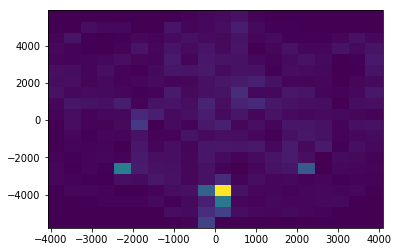

In [14]:
p0_xy = df0['Hunter746'][["pos_x", "pos_y"]].dropna()
x = p0_xy['pos_x']
y = p0_xy['pos_y']
plt.hist2d(x,y, bins=20)
plt.show()

In [15]:
proto0 = data_manager.get_proto(replays[1])

In [16]:
# (verbose)
proto0.game_metadata.team_size

3

## Data Retrieval (TODO)

This stage retrieves replays from the internet, and caches them locally.


### Train / Validation / Test Split (TODO)

Data partitioning should be done on a per-replay basis, so that there are no chances for the model to memorize similar frames from the same replay.

In [39]:
class Replay(object):
    def __init__(self, df, proto):
        self.df = df
        self.proto = proto

def get_replay(replay_id, manager):
    df = manager.get_pandas(replay_id)
    proto = manager.get_proto(replay_id)
    if df is None or proto is None:
        return None
    return Replay(df, proto)

def partition_replays(replay_list):
    return (
        list(filter(_is_train_partition, replay_list)),
        list(filter(_is_validate_partition, replay_list)),
        list(filter(_is_test_partition, replay_list)),
    )

_TRAIN_PARTITION = (1 - TEST_RATIO - VALIDATE_RATIO) * PARTITION_RANGE
_TEST_PARTITION = (1 - TEST_RATIO) * PARTITION_RANGE

def _is_train_partition(replay_id):
    id_value = abs(hash(replay_id)) % PARTITION_RANGE
    return id_value < _TRAIN_PARTITION

def _is_validate_partition(replay_id):
    id_value = abs(hash(replay_id)) % PARTITION_RANGE
    return id_value >= _TRAIN_PARTITION and id_value < _TEST_PARTITION

def _is_test_partition(replay_id):
    id_value = abs(hash(replay_id)) % PARTITION_RANGE
    return id_value >= _TEST_PARTITION

In [40]:
# for now, we will just do a manual split of the first 10 replays
replays = data_manager.get_replay_list(num=50)
train_replays, validate_replays, test_replays = partition_replays(replays)

In [41]:
len(train_replays), len(validate_replays), len(test_replays)

(26, 9, 15)

## Preprocessing

This stage takes replay dataframes and protobufs and prepares them as a numpy matrix suitable for model ingestion and analysis. There are 2 possible schemas I want to explore for state representation. 


### Schema: analog positions (DONE)

Records shall be represented as position vectors as shown below

```
<ball> <t0_p0> <t0_p1> <t0_p2> <t1_p0> <t1_p1> <t1_p2>
foreach: <pos_x> <pos_y> <pos_z>
```

### Schema: rasterized positions (TODO)

Records shall be represented as 3-channel rasterized images, with a channel each for ball, team_0, and team_1.   This can be generated from the condensed positions.

### Filtering (TODO)

Starting positions are likely to be over-represented in this dataset.  It may be useful to filter out all frames before a ball has been hit.

### Reordering (TODO)

The data could then be expanded to capture the symmetries of team and player reordering.  Player ordering in the condensed schema is arbitrary, and each record could generate `3! * 3! = 36` permutations. Team ordering is not arbitrary, but teams could be swapped by negating `pos_y` values.  This would increase the total available permutations to `36 * 2 = 72`.  There is also x-axis symmetry, so by negating X values we get another mirror, bringing it to `72 * 2 = 144` permutations.

### Distortion (TODO)

Optionally, it would be possible to slightly randomize positions, in order to help generalize.


### Dropout (TODO)

The original plan was to omit one player, and make the predictor guess it. If we are already have generated all reorderings, it should be sufficient to simply omit the final player.  However, I would also like to explore the possibility of a GAN or Autoencoder where one position within a valid record is fabricated, and the predictor must reconstruct the valid position from the invalid one.

In [42]:
def analog_positions(replay):
    assert replay is not None
    proto = replay.proto
    dataframe = replay.df
    assert proto is not None
    assert dataframe is not None
    ball_posn = get_named_posn(dataframe, 'ball')
    ball_posn = add_col_prefix(ball_posn, "ball_")
    t0_posns = []
    t1_posns = []
    for player in proto.players:
        posn = get_named_posn(dataframe, player.name)
        if player.is_orange == 0:
            t0_posns.append(posn)
        else:
            t1_posns.append(posn)
    for i, posn in enumerate(t0_posns):
        t0_posns[i] = add_col_prefix(posn, 't0_p{}_'.format(i))
    for i, posn in enumerate(t1_posns):
        t1_posns[i] = add_col_prefix(posn, 't1_p{}_'.format(i))
    positions = [ball_posn] + t0_posns + t1_posns
    return pd.concat(positions, axis=1).dropna()

def get_named_posn(dataframe, name):
    return dataframe[name][POSITION_COLUMNS]

def get_named_player(proto, player_name):
    for player in proto.players:
        if player.name == player_name:
            return player
    raise ValueError("Could not find player: " + player_name)
    
def add_col_prefix(dataframe, prefix):
    return dataframe.rename(lambda col: prefix + col, axis='columns')

In [43]:
loaded_replays = filter(lambda r: r is not None, (get_replay(replay_name, data_manager) for replay_name in train_replays))
train_aps = pd.concat((analog_positions(r) for r in loaded_replays), axis=0)

Failure to read pandas [] from memory: Struct error
Traceback (most recent call last):
  File "/home/axelmagn/workspace/saltieRL/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/numpy_manager.py", line 49, in get_array
    starting_byte = struct.unpack('i', chunk)[0]
struct.error: unpack requires a buffer of 4 bytes

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/axelmagn/workspace/saltieRL/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/pandas_manager.py", line 27, in safe_read_pandas_to_memory
    return PandasManager.read_numpy_from_memory(buffer)
  File "/home/axelmagn/workspace/saltieRL/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/pandas_manager.py", line 40, in read_numpy_from_memory
    array = read_array_from_file(buffer)
  File "/home/axelmagn/workspace/saltieRL/ReplayModels/venv/lib/python3.7/site-packages/carball/analysis/utils/numpy_manager

In [45]:
loaded_replays = filter(lambda r: r is not None, (get_replay(replay_name, data_manager) for replay_name in validate_replays))
validate_aps = pd.concat((analog_positions(r) for r in loaded_replays), axis=0)

In [46]:
# Split features and targets
def get_analog_features(analog_positions_dataframe):
    return analog_positions_dataframe.values[:,:-NCOLS]

def get_analog_targets(analog_positions_dataframe):
    return analog_positions_dataframe.values[:,-NCOLS:]

# TODO: split train, validation, and test sets based on multiple replays

In [47]:
train_features = get_analog_features(train_aps)
train_targets = get_analog_targets(train_aps)
validate_features = get_analog_features(validate_aps)
validate_targets = get_analog_targets(validate_aps)

## Model Selection

This stage evaluates different models on the training data.  Below is a list of model hypotheses that should be considered.

### Models

#### Random (Null Hypothesis) (TODO)

Our null hypothesis is that our predictor does not add any information to the problem, and we might as well be guessing a position from a distribution.  There are a number of possible distributions we could draw from:

1. Uniform
2. Gaussian
3. KDE / Histogram of training values

#### XGBoost (Baseline) (In Progress)

XGBoost performs well at many complex regression problems, and is easy to apply using a library.  It will serve as the baseline against which more sophisticated model hypotheses can be compared.

#### Clustering / KNN (Baseline) (TODO)

Another simple solution would be to retrieve similar memorized positions.

#### Deep Neural Networks (TODO)

After baselines have been measured, more sophisticated models such as convolutional neural networks can be considered.

### Selection Criteria

As important as the models is our criteria for evaluating them.  Since this problem does not easily map to a real-world loss function, this can be somewhat arbitrary, and may depend on the output schema.

#### RMSE (Single Output Schema)

If the model is outputting a single guess, it makes sense to use a simple RMSE to evaluate model performance.

#### Probability Weighted RMSE (Distribution Output Schema)

If the model outputs a probability distribution across multiple possible positions, I think it makes sense to add up the RMSE of those positions, multiplied by their predicted probability weight.



In [66]:
# from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## XGBoost

Determine the characteristics of XGBoost

In [69]:
def xgb_model():
    param = { 'objective':'reg:squarederror', 'learning_rate': 0.01 }
    num_round = 500
    evallist = [(dtrain, 'train'), (dvalid, 'eval'),]
    evals_result = {}
    return MultiOutputRegressor(xgb.XGBRegressor(learning_rate=0.01, objective='reg:squarederror'))

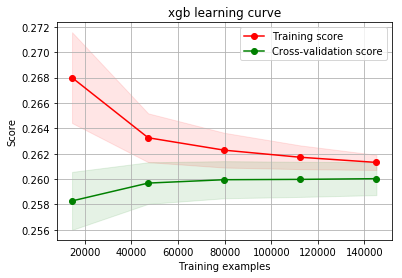

In [72]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = xgb_model()
plot_learning_curve(estimator, "xgb learning curve", train_features, train_targets, cv=cv, n_jobs=4)
plt.show()